In [1]:
%load_ext autoreload
%autoreload 2

### imports and utilities

In [30]:
from collections import Counter

from utils import *
from word_network import WordNetwork

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from scipy.stats import entropy as calculate_entropy


from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.datasets import fetch_20newsgroups
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

### load dataset

In [52]:
# total number of samples needed
randomize = False

# retrieve dataset
categories = ['rec.autos', 'talk.politics.mideast', 'comp.graphics', 'sci.space']

docs = fetch_20newsgroups(subset='train', shuffle=randomize, remove=('headers', 'footers', 'quotes'), categories=categories)
docs, old_labels, classes = docs.data, docs.target, docs.target_names

### clean dataset

In [54]:
datasize = 100
max_document_length = None

index = -1
clean_docs, labels = [], []

sizes = [0]*len(categories)

with tqdm(total=len(categories)*datasize) as pbar:
    while sum(sizes) != len(categories)*datasize:
        index += 1
        size_index = categories.index(classes[old_labels[index]])
        
        if sizes[size_index] == datasize:
            continue
        
        doc = docs[index]
        status, doc, word_count = clean_doc(doc, True)
        
        if (not status) or (max_document_length is not None and len(doc) > max_document_length):
            continue
        
        labels.append(categories[size_index])
        clean_docs.append(doc)
        sizes[size_index] += 1
        pbar.update(1)

labels = np.array(labels)


i don t like this comment about typical think you could state your interpretation of exodus without it a i read exodus i can see a lot of kill there which be paint by the author of the bible in ideological religious color the history in the desert can be see a an ethos of any nomadic people occupy a land that s why i think it be a great book with which descendant arab turk and mongol can unify a well


In [237]:
index = 13
print(f"Topic: {labels[index]}\n{'='*50}\n{clean_docs[index]}")

Topic: talk.politics.mideast
first of all i never say the holocaust i say before the holocaust i m not ignorant of the holocaust and know more about nazi germany than most people maybe include you what i resent be ignorant statement that call people name when they disagree with your position oppose the atrocity commit by the israeli governement hardly qualifies a anti semitism if you think name call be a valid form of argument in intellectual circle you need to get out more often i don t think the suffer of some jew during wwii justifies the crime commit by the israeli government any attempt to call civil liberterians like myself anti semetic be not appreciate


In [64]:
print(sizes)
assert min(sizes) == max(sizes) == datasize

[100, 100, 100, 100]


In [65]:
print(f"there are {len(clean_docs)} docs")

there are 400 docs


### count words

In [66]:
# mode = "tfidf"
# mode = "binary"
# mode = "normalize"
# mode = "binary-normalize"
mode = "pmi"

# initialize the count vectorizer
vectorizer = TfidfVectorizer() if mode == "tfidf" else CountVectorizer()

# fit it to dataset
train_docs, test_docs = clean_docs, []
# train_docs, test_docs = train_test_split(clean_docs, test_size=.33, random_state=42)

vectorizer.fit(train_docs)
vocabulary = vectorizer.get_feature_names()

print("word_count is", len(vocabulary))

word_count is 10006


### Prepare Datatset

In [67]:
# create doc count vectors
train_doc_vectors = vectorizer.transform(train_docs).toarray()
test_doc_vectors = vectorizer.transform(test_docs).toarray()

if mode in ["binary-normalize", "binary", "pmi"]:
    train_doc_vectors = (train_doc_vectors > 0).astype(float)
    test_doc_vectors = (test_doc_vectors > 0).astype(float)
    
if mode == "normalize" or mode == "binary-normalize":
    train_doc_vectors = normalize(train_doc_vectors, norm="l1", axis=1)
    test_doc_vectors = normalize(test_doc_vectors, norm="l1", axis=1)

print(f"{len(train_doc_vectors)} train_docs, {len(test_doc_vectors)} test docs")

400 train_docs, 0 test docs


### Word-Word Ratio

In [68]:
#reduce freq in doc to bin value of 1 or 0
word_doc_freqency = pd.DataFrame(train_doc_vectors, columns=vocabulary)

#the sum vertically of bin freq
word_doc_total_frequency = word_doc_freqency.sum(0)

word_word_co = pd.DataFrame(data=0.0, columns=vocabulary, index=vocabulary)

word_frequency_norm = ((word_doc_freqency > 0).sum(0) / len(train_doc_vectors))
p = pd.DataFrame((train_doc_vectors.sum(0) / len(train_doc_vectors)), columns=[0], index=vocabulary)[0]

for word in tqdm(vocabulary):
    pxy = word_doc_freqency[word_doc_freqency[word] == 1].sum(0) / len(train_doc_vectors)
    word_word_co[word] = sigmoid(np.nan_to_num(np.log2(pxy / (p[word] * p))))

# word_word_co = (word_word_co.T / word_word_co.sum(1)).T
print(f"word_word_co has shape {word_word_co.shape}")

c:\program files\python37\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\christian\Documents\christian\work\python\cyberspace\semantic_segmentation\utils.py:15: RuntimeWarning: overflow encountered in power
  return 1 / (1 + (np.e**-x))



word_word_co has shape (10006, 10006)


In [69]:
# #reduce freq in doc to bin value of 1 or 0
# word_doc_freqency = pd.DataFrame(train_doc_vectors, columns=vocabulary)

# #the sum vertically of bin freq
# word_doc_total_frequency = word_doc_freqency.sum(0)

# word_word_co = pd.DataFrame(data=0.0, columns=vocabulary, index=vocabulary)
# word_frequency_norm = ((word_doc_freqency > 0).sum(0) / len(train_doc_vectors))

# for word in tqdm(vocabulary):
#     word_word_frequency = word_doc_freqency[word_doc_freqency[word] > 0].sum(0)
#     word_word_co[word] = ((word_word_frequency * word_frequency_norm) / word_doc_total_frequency).fillna(0)

# # word_word_co = (word_word_co.T / word_word_co.sum(1)).T
# print(f"word_word_co has shape {word_word_co.shape}")

In [70]:
word_word_co.head()

,00,000,0007,000th,0029,007,01,011,0119,013,...,zionist,zip,zippy,zman,zone,zoo,zoom,zorn,zulu,zur
00,0.999521,0.000000,0.999521,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.999521,0.000000,0.0,0.0,0.998700,0.0,0.0,0.0
000,0.000000,0.989609,0.000000,0.000000,0.000000,0.989609,0.000000,0.0,0.0,0.0,...,0.903302,0.0,0.000000,0.989609,0.0,0.0,0.000000,0.0,0.0,0.0
0007,0.999521,0.000000,0.999824,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.999824,0.000000,0.0,0.0,0.999521,0.0,0.0,0.0
000th,0.000000,0.000000,0.000000,0.999824,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
0029,0.000000,0.000000,0.000000,0.000000,0.999824,0.000000,0.999141,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0


### Calculate Word Trust ratio

In [71]:
word_entropy = pd.DataFrame(data=np.nan_to_num(calculate_entropy(word_word_co.T, base=2)), columns=[0], index=vocabulary)[0]
word_trust_factor = pd.DataFrame(data=gaussian2(word_entropy), columns=[0], index=vocabulary)[0]

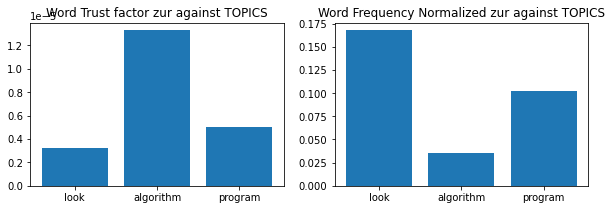

In [72]:
words = ["look", "algorithm", "program"]
# words = ["looking", "algorithm", "program", "the", "to", "of"]

fig = plt.figure(figsize=(10,3))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.set_title(f"Word Trust factor {word} against TOPICS")
ax1.bar(words, (word_trust_factor)[words])

ax2.set_title(f"Word Frequency Normalized {word} against TOPICS")
ax2.bar(words, word_frequency_norm[words])

plt.show()

### Observe word_word_co ratios

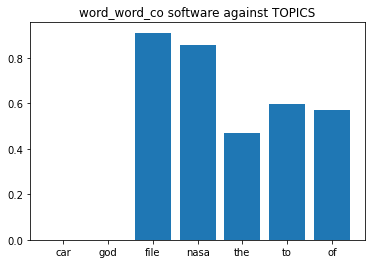

In [73]:
word = "software"
words = ["car", "god", "file", "nasa", "the", "to", "of"]

plt.title(f"word_word_co {word} against TOPICS")
plt.bar(words, word_word_co.loc[word][words])

plt.show()

In [74]:
word_word_co.loc[word].sort_values(ascending=False).head(15)

arbitrary           0.990471
sunview             0.990471
ultrix              0.990471
615                 0.990471
multidimensional    0.990471
61820               0.990471
619                 0.990471
ultimage            0.990471
bris                0.990471
multiplot           0.990471
brush               0.990471
sunspot             0.990471
627                 0.990471
multiprocessor      0.990471
multispectral       0.990471
Name: software, dtype: float64

### Update word_word_co with gaussian entropy

In [205]:
# word_word_co = (word_word_co + (word_word_co * word_word_co.T)) * word_trust_factor
word_word_co = (word_word_co * word_trust_factor)
word_word_co = (word_word_co.T / word_word_co.sum(1)).T

### Observe word_word_co ratios

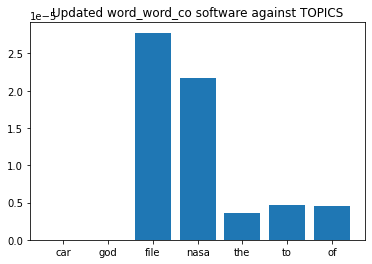

In [206]:
plt.title(f"Updated word_word_co {word} against TOPICS")
plt.bar(words, word_word_co.loc[word][words])

plt.show()

In [207]:
word_word_co.loc[word].sort_values(ascending=False).head(15)

showing          0.024811
apparantly       0.024811
ce               0.024811
3do              0.024811
licensee         0.024811
decompression    0.019568
25mhz            0.019568
tttddd           0.019544
stereo           0.015056
sys              0.015056
piccy            0.013696
ruu              0.013696
jhwitten         0.013696
dir              0.013696
jpegs            0.013696
Name: software, dtype: float64

In [208]:
word_entropy2 = pd.DataFrame(data=np.nan_to_num(calculate_entropy(word_word_co.T, base=2)), columns=[0], index=vocabulary)[0]
word_trust_factor2 = pd.DataFrame(data=gaussian2(word_entropy2), columns=[0], index=vocabulary)[0]

### Update word_word_co with word_word_co

In [75]:
# wwc = pd.DataFrame(data=0.0, columns=vocabulary, index=vocabulary)

# for word in tqdm(vocabulary):
#     for other_word in vocabulary:
#         ratios = word_word_co.loc[word][other_word] * word_word_co.loc[other_word]
#         wwc.loc[word][ratios > wwc.loc[word]] = ratios[ratios > wwc.loc[word]]

# print(f"word_word_co has shape {word_word_co.shape}")

In [154]:
# doc_word_distr = pd.DataFrame(data=0.0, columns=vocabulary, index=word_doc_freqency.index)
# word_doc_norm = (word_doc_freqency.T / word_doc_freqency.sum(1)).T * word_trust_factor

# for doc_index in tqdm([0]):#range(len(train_doc_vectors))):
#     wv = word_doc_norm.iloc[0]
#     wv_indices = wv[wv > (wv.max() - wv.std())].index
#     doc_word_distr.iloc[doc_index] = (word_word_co.loc[wv_indices] * word_doc_norm.iloc[doc_index]).max(0)

# print(f"doc_word_distr has shape {doc_word_distr.shape}")

In [183]:
doc_word_distr = (word_doc_freqency.T / word_doc_freqency.sum(1)).T * word_trust_factor
doc_word_distr = (doc_word_distr.T / doc_word_distr.sum(1)).T.fillna(0)

In [184]:
print((word_doc_freqency.iloc[0] * word_trust_factor).sort_values(ascending=False).head(10))

interpretation    0.003220
ethos             0.003220
mongol            0.003220
unify             0.003220
exodus            0.003220
nomadic           0.003220
desert            0.003220
ideological       0.000675
bible             0.000439
descendant        0.000210
Name: 0, dtype: float64


In [216]:
print((doc_word_distr.iloc[10]).sort_values(ascending=False).head(10))

desintegrated    0.944805
surgical         0.036779
directly         0.003222
missile          0.002453
someone          0.001305
hit              0.001198
destroy          0.001196
course           0.001151
house            0.001135
kill             0.000910
Name: 10, dtype: float64


In [186]:
doc_word_distr.iloc[0].sum()

1.0000000000000002

In [187]:
print(labels[0], train_docs[0])

talk.politics.mideast i don t like this comment about typical think you could state your interpretation of exodus without it a i read exodus i can see a lot of kill there which be paint by the author of the bible in ideological religious color the history in the desert can be see a an ethos of any nomadic people occupy a land that s why i think it be a great book with which descendant arab turk and mongol can unify a well


In [188]:
doc_word_distr.head()

,00,000,0007,000th,0029,007,01,011,0119,013,...,zionist,zip,zippy,zman,zone,zoo,zoom,zorn,zulu,zur
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Define Latent partitions

In [217]:
# reduction = None
# reduction = "pca"
reduction = "normal"

if reduction is None:
    columns = doc_word_distr.columns
    param_values = doc_word_distr.values

if reduction == "pca":
    num_of_components = 126
    columns = list(range(num_of_components))
    
    pca = PCA(n_components=num_of_components)
    param_values = pca.fit_transform(doc_word_distr)

if reduction == "normal":
    columns = ["mean", "std"]
    param_values = np.array([doc_word_distr.mean(1), doc_word_distr.std(1)]).T
    
distr_params = pd.DataFrame(data=param_values, columns=columns, index=list(range(len(doc_word_distr))))
print(f"distr_params has shape {distr_params.shape}")

distr_params has shape (400, 2)


In [218]:
distr_params.head()

,mean,std
0,0.0001,0.003543
1,0.0001,0.009160
2,0.0001,0.001676
3,0.0001,0.003310
4,0.0001,0.006993


### Using Kmeans MiniBatch

In [219]:
num_of_topics = 4
kmeans_model = MiniBatchKMeans(n_clusters=num_of_topics, random_state=0)

In [220]:
num_of_iterations = 1024

num_of_samples = len(distr_params)
batch_size = num_of_samples // 2

for i in tqdm(range(num_of_iterations)):
    indices = np.random.randint(num_of_samples, size=batch_size)
    
    kmeans_model.partial_fit(distr_params.iloc[indices])

kmeans_model.cluster_centers_.shape

(4, 2)

In [321]:
dist = kmeans_model.transform(distr_params)
predicted_labels = kmeans_model.predict(distr_params)

# wtf = normalize(dist, norm="l1", axis=1)
# wtf = normalize(wtf, norm="l1", axis=0)

wtf = (dist / dist.max(0))

print(f"dist has shape {dist.shape}, predicted_labels has shape {predicted_labels.shape}")

dist has shape (400, 4), predicted_labels has shape (400,)


In [327]:
voc_array = np.array(vocabulary)

def get_top2(topic):
    indices = dist[:, topic].argsort()
    print(labels[indices[:10]])

def get_top2(topic):
    indices = np.where(predicted_labels == topic)[0]
    print((doc_word_distr.T * wtf[:, 0]).T.iloc[indices].mean(0).sort_values(ascending=False).head(10))

def get_top2(topic):
    indices = np.where(predicted_labels == topic)[0]
    print(((doc_word_distr.T * wtf[:, 0]).T.iloc[indices].sum(0) * word_trust_factor).sort_values(ascending=False).head(10))
    
def get_top(topic):
    indices = np.where(predicted_labels == topic)[0]
    print(Counter(labels[indices]))

In [328]:
get_top(0)

Counter({'comp.graphics': 15, 'rec.autos': 8, 'talk.politics.mideast': 8, 'sci.space': 6})


In [329]:
get_top(1)

Counter({'sci.space': 45, 'comp.graphics': 44, 'rec.autos': 39, 'talk.politics.mideast': 22})


In [330]:
get_top(2)

Counter({'rec.autos': 28, 'comp.graphics': 17, 'sci.space': 17, 'talk.politics.mideast': 14})


In [326]:
get_top(3)

saab          0.000003
bound         0.000003
advance       0.000003
azarbaijan    0.000003
standoff      0.000003
mainland      0.000003
success       0.000003
soc           0.000003
tankut        0.000003
sabri         0.000003
dtype: float64


### Evaluate Topic model with Train set

In [65]:
score = 0
misclassified_train = []
print("Evaluating Topic Model...")

for doc_index in tqdm(range(len(train_labels))):
    doc_vector = train_doc_vectors[doc_index]
    
    doc_topic_word_distr, doc_topic = infer_topic(label_classes, doc_vector, topic_word_distr)
    score += int(doc_topic == label_classes[train_labels[doc_index]])
    
    if doc_topic != label_classes[train_labels[doc_index]]:
        misclassified_train.append(doc_index)
    
train_accuracy = score / (doc_index + 1)
print(f"==> train-accuracy is {train_accuracy*100:.2f}%, {len(misclassified_train)} misclassified\n")

Evaluating Topic Model...



==> train-accuracy is 90.67%, 25 misclassified



### Evaluating Topic Model with test set

In [66]:
score = 0
print("Evaluating Topic Model...")

misclassified_test = []
for doc_index in tqdm(range(len(test_labels))):
    doc_vector = test_doc_vectors[doc_index]
    
    doc_topic_word_distr, doc_topic = infer_topic(label_classes, doc_vector, topic_word_distr)
    score += int(doc_topic == label_classes[test_labels[doc_index]])
    
    if doc_topic != label_classes[test_labels[doc_index]]:
        misclassified_test.append(doc_index)
    

test_accuracy = score / (doc_index + 1)
print(f"==> test-accuracy is {test_accuracy*100:.2f}%, avg-accuarcy = {.5*(train_accuracy + test_accuracy)*100:.2f}%, {len(misclassified_test)} misclassified\n")

Evaluating Topic Model...



==> test-accuracy is 54.55%, avg-accuarcy = 72.61%, 60 misclassified



### Investigating Misclassification

In [89]:
training = True
tlabels = train_labels if training else test_labels
tdoc_vectors = train_doc_vectors if training else test_doc_vectors
misclassified = misclassified_train if training else misclassified_test

for doc_index in tqdm(misclassified):
    doc_vector = tdoc_vectors[doc_index]
    doc_topic_word_distr, doc_topic = infer_topic(label_classes, doc_vector, topic_word_distr)
    
    xv = doc_topic_word_distr.iloc[np.where(doc_topic_word_distr.sum(1) > 0)]
    print(xv.loc[xv.sum(1).sort_values(ascending=False).index])
    print(train_docs[doc_index])
    print(f"==> predicted_topic = {doc_topic}, actual_topic = {label_classes[tlabels[doc_index]]} \n")
#     break

              autos  religion  graphics     space
ve         0.000334  0.000191  0.001622  0.000000
sense      0.000426  0.001182  0.000000  0.000000
maybe      0.000000  0.000906  0.000605  0.000000
shot       0.000000  0.000677  0.000000  0.000371
that       0.000299  0.000251  0.000241  0.000251
kind       0.000000  0.000394  0.000588  0.000000
cheap      0.000000  0.000954  0.000000  0.000000
embarrass  0.000000  0.000954  0.000000  0.000000
fundies    0.000000  0.000954  0.000000  0.000000
josh       0.000000  0.000954  0.000000  0.000000
mood       0.000000  0.000954  0.000000  0.000000
mcdowell   0.000000  0.000954  0.000000  0.000000
be         0.000165  0.000224  0.000176  0.000203
of         0.000119  0.000248  0.000176  0.000181
to         0.000140  0.000208  0.000155  0.000176
okay       0.000000  0.000375  0.000293  0.000000
except     0.000307  0.000350  0.000000  0.000000
who        0.000148  0.000316  0.000030  0.000111
but        0.000055  0.000224  0.000197  0.000128


may       0.000021  0.000090  0.000056  0.000031
from phil g fraering pgf srl03 cacs usl edu right the profit caste be bless by god and may freely blare it presence in the even twilight
==> predicted_topic = religion, actual_topic = space 

            autos  religion  graphics     space
help     0.000000  0.000315  0.001873  0.000330
the      0.000425  0.000436  0.000395  0.000502
rest     0.000000  0.000886  0.000000  0.000424
shirt    0.000000  0.001130  0.000000  0.000000
night    0.000000  0.001130  0.000000  0.000000
delete   0.000000  0.001130  0.000000  0.000000
brown    0.000000  0.001130  0.000000  0.000000
of       0.000141  0.000293  0.000209  0.000215
out      0.000276  0.000259  0.000199  0.000120
in       0.000158  0.000150  0.000188  0.000167
can      0.000104  0.000085  0.000193  0.000155
about    0.000169  0.000113  0.000081  0.000073
anybody  0.000088  0.000057  0.000209  0.000041
find     0.000124  0.000046  0.000141  0.000030
rest delete can anybody out in a p h he

### Using Latent Dirichlet Allocation

In [68]:
clf = MultinomialNB(alpha=.01)
clf.fit(train_doc_vectors, train_labels)

train_accuracy = clf.score(train_doc_vectors, train_labels)
test_accuracy = clf.score(test_doc_vectors, test_labels)

print(f"training_accuarcy = {train_accuracy*100:.2f}%, test_accuarcy = {test_accuracy*100:.2f}%, avg-accuarcy = {.5*(train_accuracy + test_accuracy)*100:.2f}%")

training_accuarcy = 100.00%, test_accuarcy = 62.88%, avg-accuarcy = 81.44%
